# Generate standard comparison metrics

These are a set of standard kinematics for comparing models and data.

- Mean energy binned along;
    * Radius from shower axis
    * layer
- Number of cells binned along visible cell energy
- Number of showers binned along
    * center of gravity in x
    * center of gravity in y (detector coords)
    * center of gravity in z (detector coords)
    * number of hits
    * energy sum

Lining up these distributions with geant 4 shows good simulation behaviour.

## Start with imports and config


In [1]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np

from pointcloud.config_varients.wish_maxwell import Configs as MaxwellConfigs
from pointcloud.configs import Configs
from pointcloud.evaluation.bin_standard_metrics import (
    BinnedErrors,
    DetectorBinnedData,
    BinnedData,
    get_path,
)

config = Configs()

## Histogramming

BinnedData is a class that takes sets of points and accumulates them for each of the binnings we are intrested in.
This class, and related uitilites are in `pointclouds/evaluation/bin_standard_metrics.py`.
We have preped and generated data in this class using `scripts/create_standard_metrics.py`.



## Data as BinnedData

For Geant 4, the accumulator and each of the models, load the generate binned data

Geant 4 is our ground truth, so it gets special treatment.

In [2]:
g4_name = "Geant 4"


def get_path_or_ref(config, name):
    """
    Get a path to the binned data from the logdir in the config,
    or if not found, check the reference folder.
    """
    ref_dir = "standard_metrics_ref"
    try:
        save_path = get_path(config, name)
    except FileNotFoundError:
        save_path = ""
    if not os.path.exists(save_path):
        print(f"Didn't find binned data for {name} in {save_path}")
        ref_path = os.path.join(ref_dir, name.replace(" ", "_") + ".npz")
        print(f"Checking for stored reference in {ref_dir}")
        if os.path.exists(ref_path):
            print(f"Found stored reference")
            save_path = ref_path
    return save_path

g4_save_path_proj = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/Geant_4_p22_th90_ph90_en10-100_seed0_detectorProj.npz"

binned_g4_proj = DetectorBinnedData.load(g4_save_path_proj)

100%|██████████| 30/30 [00:00<00:00, 6758.47it/s]


In [3]:
save_paths_proj = {
    "CC2": glob.glob("/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds2-ShowerFlow_CC2_p22_th90_ph90_en10-100_seed*_detectorProj.npz"),
    "CC3": glob.glob("/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds3-ShowerFlow_a1_fnorms_2_p22_th90_ph90_en10-100_seed*_detectorProj.npz"),
    "CC2 noCoG": glob.glob("/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds2-ShowerFlow_CC2_p22_th90_ph90_en10-100_noCoGCalebration_seed*_detectorProj.npz"),
    "CC3 noCoG": glob.glob("/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds3-ShowerFlow_a1_fnorms_2_p22_th90_ph90_en10-100_noCoGCalebration_seed*_detectorProj.npz"),
   #"CC2 no factor": "/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds2-ShowerFlow_CC2_p22_th90_ph90_en10-100_noFactor_detectorProj.npz",
   # "CC2 no factor, true Npts": "/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds2-ShowerFlow_CC2_p22_th90_ph90_en10-100_noFactor_detectorProj_trueNPts.npz",
    #"CC3 no factor": "/data/dust/user/dayhallh/point-cloud-diffusion-logs/binned_metrics/CaloClouds3-ShowerFlow_a1_fnorms_2_p22_th90_ph90_en10-100_noFactor_detectorProj.npz",
}
# model_names += [f"Wish-poly{poly_degree}" for poly_degree in range(1, 4)]
config.logdir = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation"

to_compare_proj = {}

for model_name, save_path in save_paths_proj.items():
    # save_path = get_path_or_ref(config, model_name)
    # save_path = "/beegfs/desy/user/weberdun/6_PointCloudDiffusion/log/binned_metrics/CaloClouds_Duncan_gen0.npz"
    if not save_path:
        print(
            f"Can't load {model_name}, recreate with create_standard_metrics.py if required"
        )
        continue
    #print(save_path)
    binned = BinnedErrors.load(save_path)
    to_compare_proj[model_name] = binned

# to_compare["G4 angular"] = binned_g4_sim

Loading detector binned data


100%|██████████| 30/30 [00:00<00:00, 1949.81it/s]


Loading detector binned data


100%|██████████| 30/30 [00:00<00:00, 1971.19it/s]


Loading detector binned data


100%|██████████| 30/30 [00:00<00:00, 2016.46it/s]


Loading detector binned data


100%|██████████| 30/30 [00:00<00:00, 1993.33it/s]


For only some of the distributions, we can also get data from the StatsAccumulator to compare;

## Plotting

Now the samples have been generated, we can focus on histogramming them.
This may require some manual adjustment to cater for the ranges in which there are significant number of counts.

In [7]:
from pointcloud.utils.plotting import plot_line_with_devation, plot_hist_with_devation

def make_hist_plots(binned_g4=binned_g4_proj, to_compare=to_compare_proj, save_tag=None):

    hist_idx_order = [0, 10, 7, 1, 11, 9, 2, 4, 8, 3, 5, 6]

    n_plts = len(hist_idx_order)
    n_rows = int(n_plts / 4)
    height_ratios = [3, 1] * n_rows

    for semilogy in [False, True]:

        fig, ax_arr = plt.subplots(
            2 * n_rows,
            4,
            figsize=(20, 5 * n_rows),
            gridspec_kw={"height_ratios": height_ratios},
        )
        ax_arr = ax_arr.T.flatten()

        if semilogy:
            fig.suptitle("Log on the y axis")
        else:
            fig.suptitle("Linear y axis")

        model_colours = [plt.cm.tab10(i / 10) for i in range(len(to_compare))]

        for i, hist_idx in enumerate(hist_idx_order):

            main_ax = ax_arr[2 * i]
            ratio_ax = ax_arr[2 * i + 1]
            ratio_ax.sharex(main_ax)

            x_label = binned_g4.x_labels[hist_idx]
            main_ax.set_xlabel(x_label)
            main_ax.set_ylabel(binned_g4.y_labels[hist_idx])
            print((x_label, binned_g4.y_labels[hist_idx]))
            if semilogy:
                main_ax.semilogy()

            # G4
            dummy_values = binned_g4.dummy_xs(hist_idx)
            weights = binned_g4.counts[hist_idx]
            # weights = binned_g4.normed(hist_idx)
            bins = binned_g4.bins[hist_idx]
            main_ax.hist(
                dummy_values,
                bins=bins,
                weights=weights,
                label=binned_g4.name,
                histtype="stepfilled",
                color="grey",
                alpha=0.5,
            )

            # print(f"Sum g4 weights {np.sum(weights)}")

            # Fix some axes
            if "center of gravity" in x_label:
                center_pos = np.nansum(dummy_values * weights) / np.nansum(weights)
                if "Z" in x_label:
                    half_width = 15
                else:
                    half_width = 6
                try:
                    main_ax.set_xlim(center_pos - half_width, center_pos + half_width)
                    pass
                except ValueError as e:
                    print(f"{x_label}, {center_pos}")
                    print(e)
            if "cluster energy" in x_label or "cell energy" in x_label:
                main_ax.loglog()
            if "energy sum" in x_label:
                main_ax.set_xlim(0, 4000)
            if "number of active cells" in x_label:
                main_ax.set_xlim(0, 2200)

            xmin, xmax = main_ax.get_xlim()
            ratio_ax.hlines([1], xmin, xmax, color='k', alpha=0.5)

            ratios = []
            # models
            for colour, model_name in zip(model_colours, to_compare):
                model = to_compare[model_name]
                # bins and dummys should be the same
                model_weights = model.counts[hist_idx]
                model_error = model.errors[hist_idx]
                # model_weights = model.normed(hist_idx)
                # print(model_weights)

                # print(f"Sum {model_name} weights {np.sum(model_weights):.2g}")
                if "rad" in x_label:
                    n_bins_here = min(len(model_weights), len(dummy_values))
                    model_weights = model_weights[:n_bins_here]
                    dummy_values_here = dummy_values[:n_bins_here]
                    bins_here = bins[: n_bins_here + 1]
                else:
                    n_bins_here = len(model_weights)
                    bins_here = bins
                    dummy_values_here = dummy_values

                plot_hist_with_devation(
                    main_ax,
                    colour=colour,
                    bins=bins_here,
                    counts=model_weights,
                    errors_up=model_error,
                    label=model_name,
                    histtype="step",
                    color=colour,
                )
                # main_ax.plot(dummy_values, model_weights, label=f"{np.sum(model_weights):.2g}")

                # and the ratio
                ratio = model_weights / weights[:n_bins_here]
                ratio_errors = model_error/model_weights
                plot_line_with_devation(
                    ratio_ax, colour, dummy_values_here, ratio, ratio_errors, label=model_name)
                #ratio_ax.plot(dummy_values_here, ratio, c=colour, label=model_name)
                ratios.append(ratio)

            all_ratios = np.concatenate(ratios)
            all_ratios = all_ratios[np.isfinite(all_ratios)]
            mean_ratio = np.nanmean(all_ratios)
            std_ratio = np.nanstd(all_ratios)
            lower_bound = max(0, mean_ratio - 3 * std_ratio)
            upper_bound = min(2, mean_ratio + 3 * std_ratio)

            ratio_ax.set_ylim(lower_bound, upper_bound)

            main_ax.legend()

        fig.tight_layout()
        if semilogy:
            text_ = "log_y"
        else:
            text_ = "linear_y"
        if save_tag is not None:
            fig.savefig(
                f"/data/dust/user/dayhallh/point-cloud-diffusion-images/CC2_vs_3_binned_metrics/compare_{save_tag}_{text_}.png",
                dpi=300,
                bbox_inches="tight",
            )
            fig.savefig(
                f"/data/dust/user/dayhallh/point-cloud-diffusion-images/CC2_vs_3_binned_metrics/compare_{save_tag}_{text_}.pdf",
                dpi=300,
                bbox_inches="tight",
            )


('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')
('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')


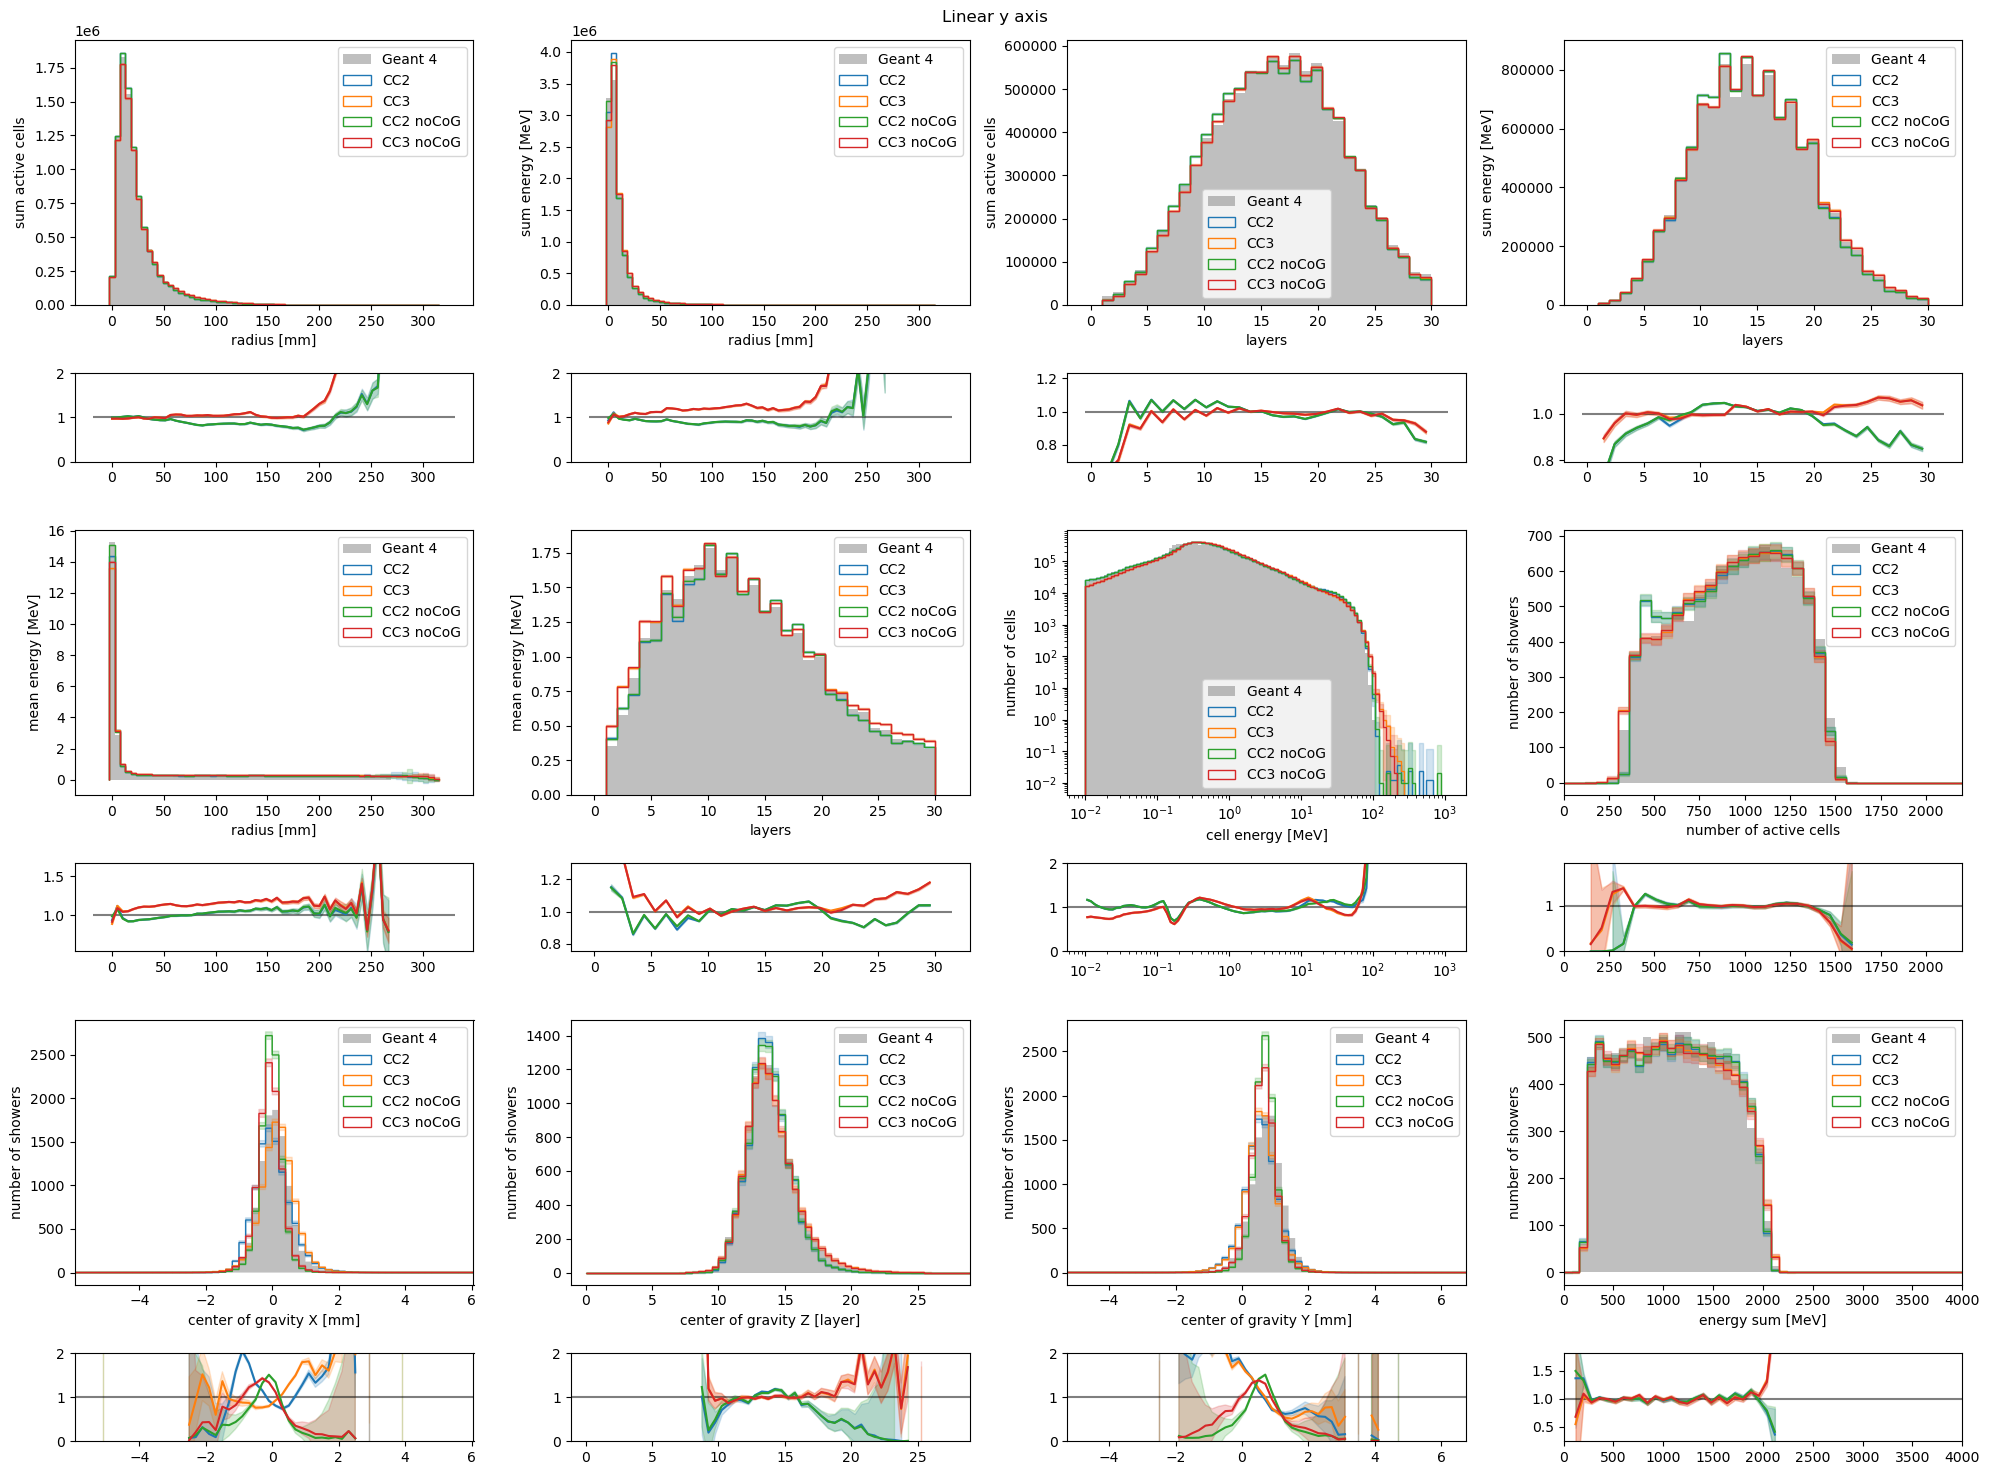

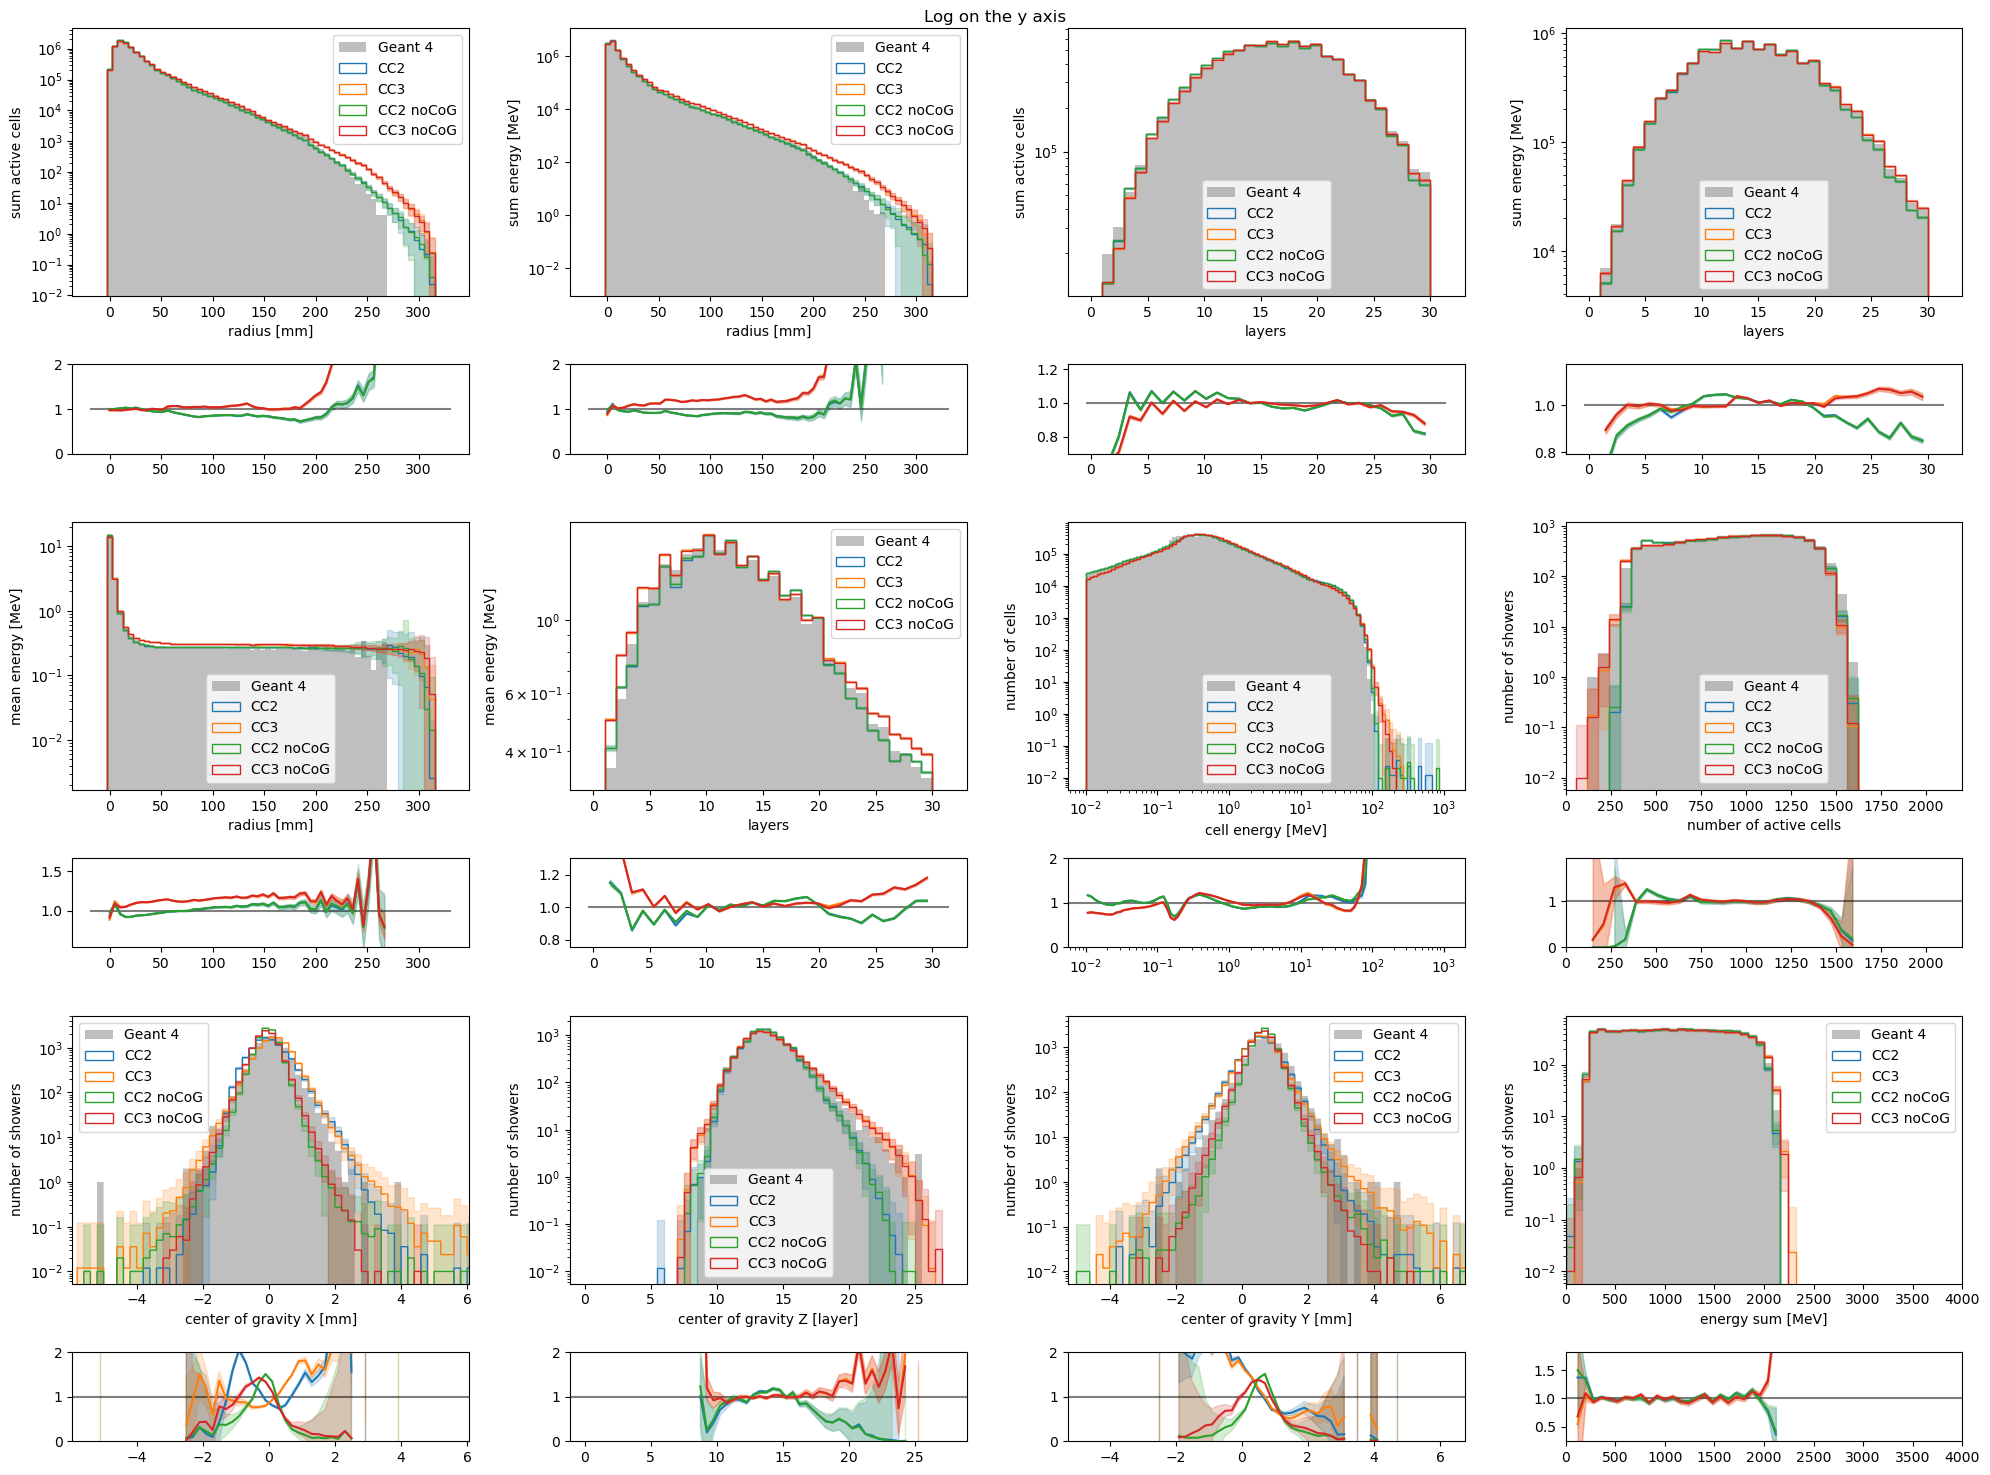

In [8]:
make_hist_plots(binned_g4_proj, to_compare_proj)

Now, CC2 and CC3 have different scale factors for matching the hits and energy deposited in cells to the true energy or hits.

('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')
('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')


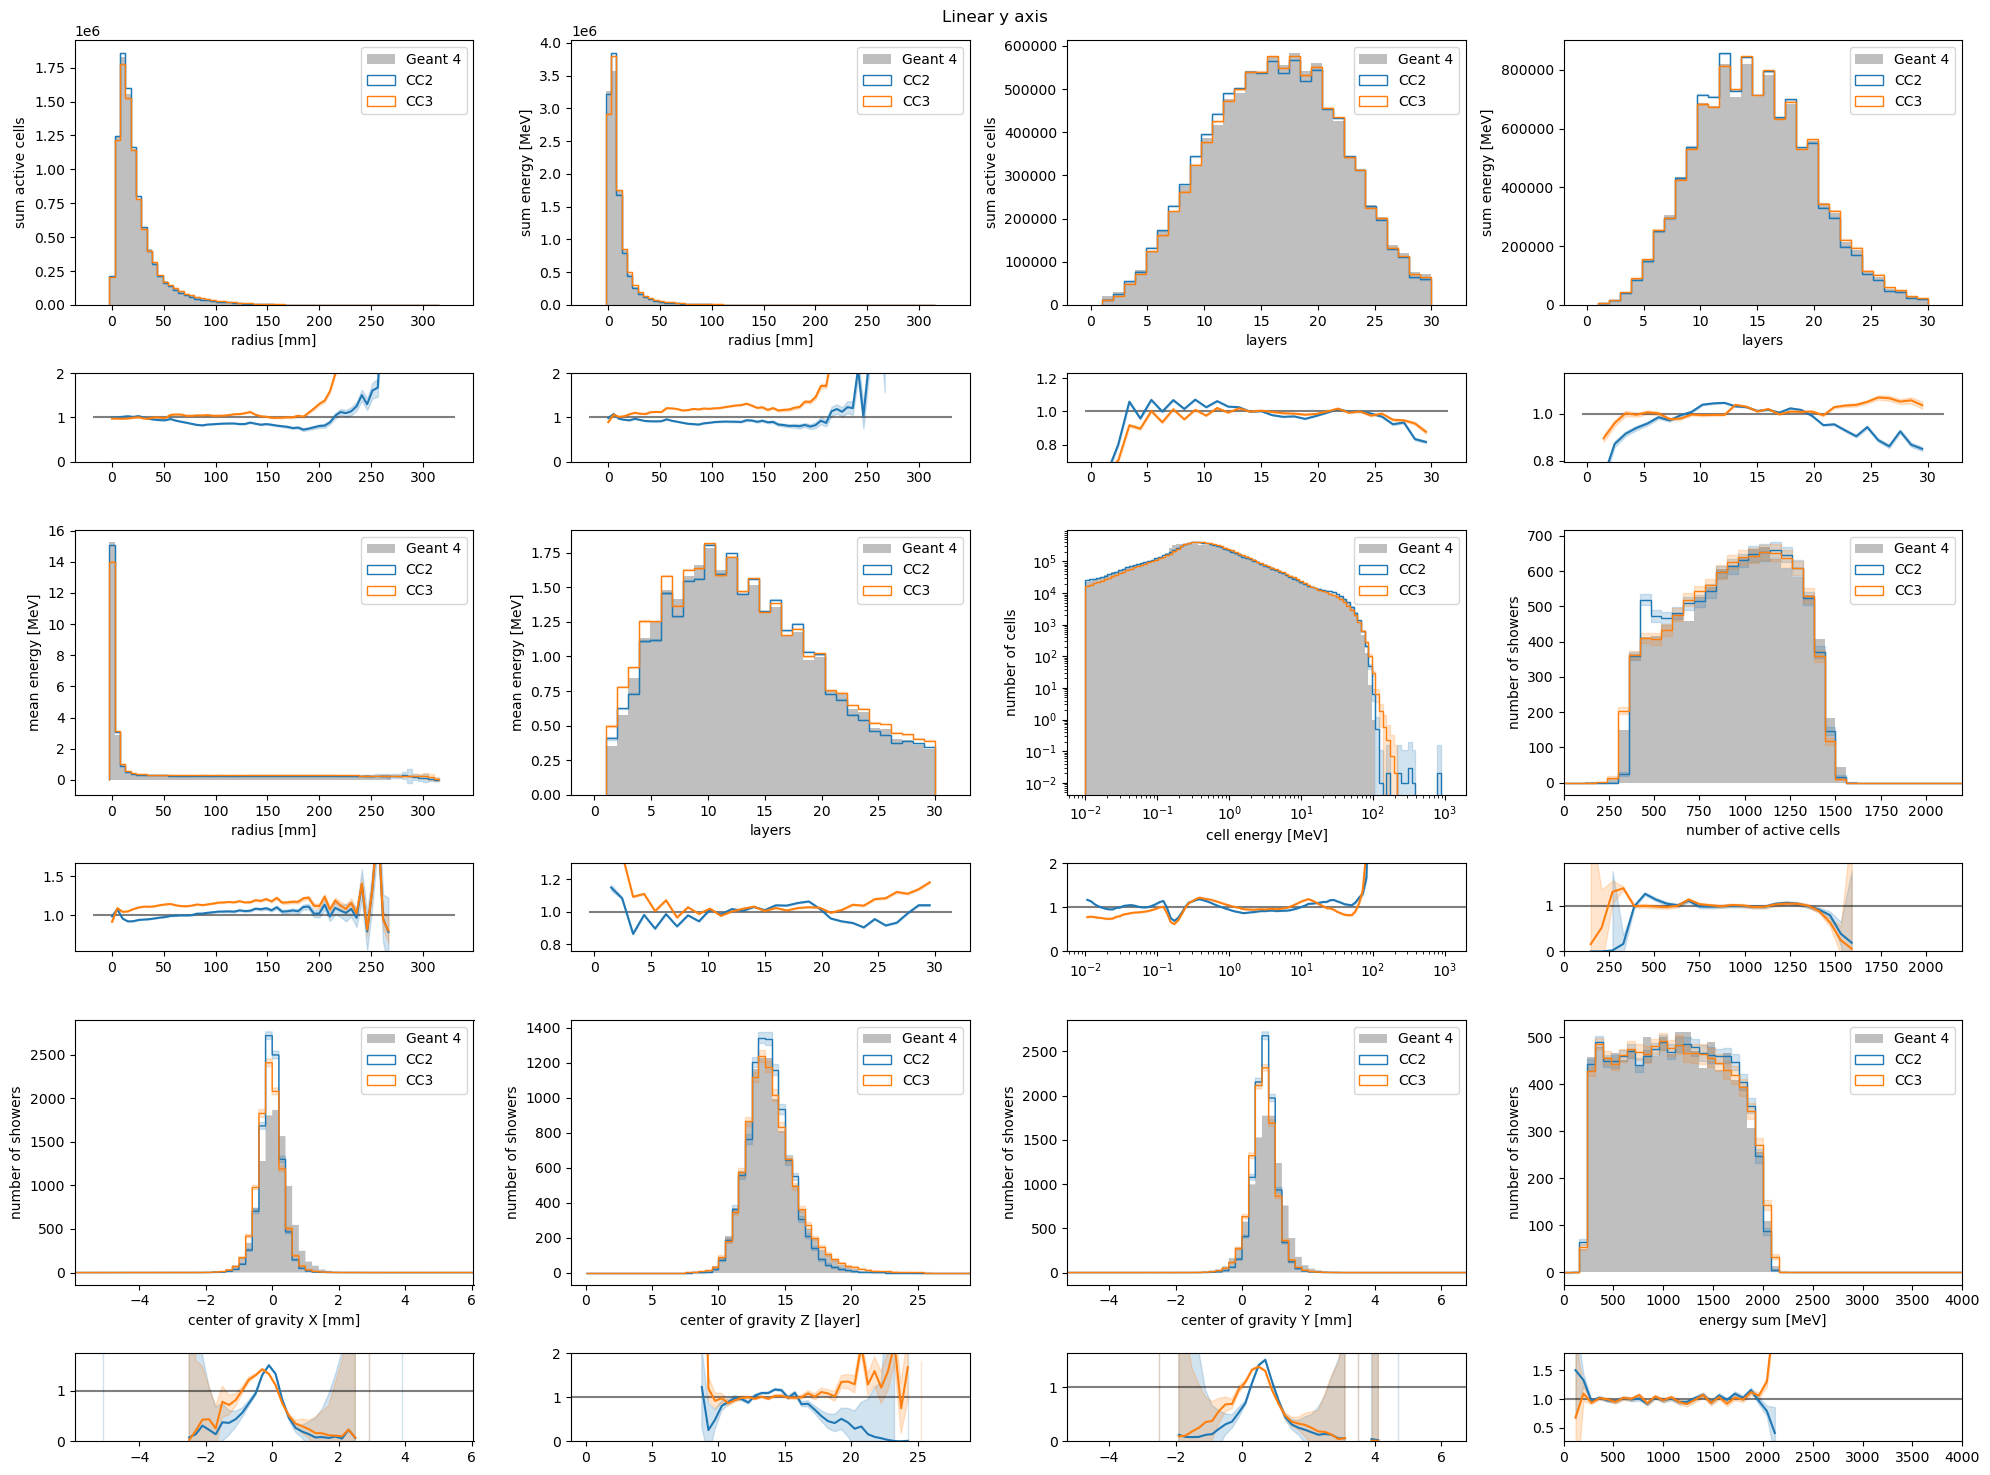

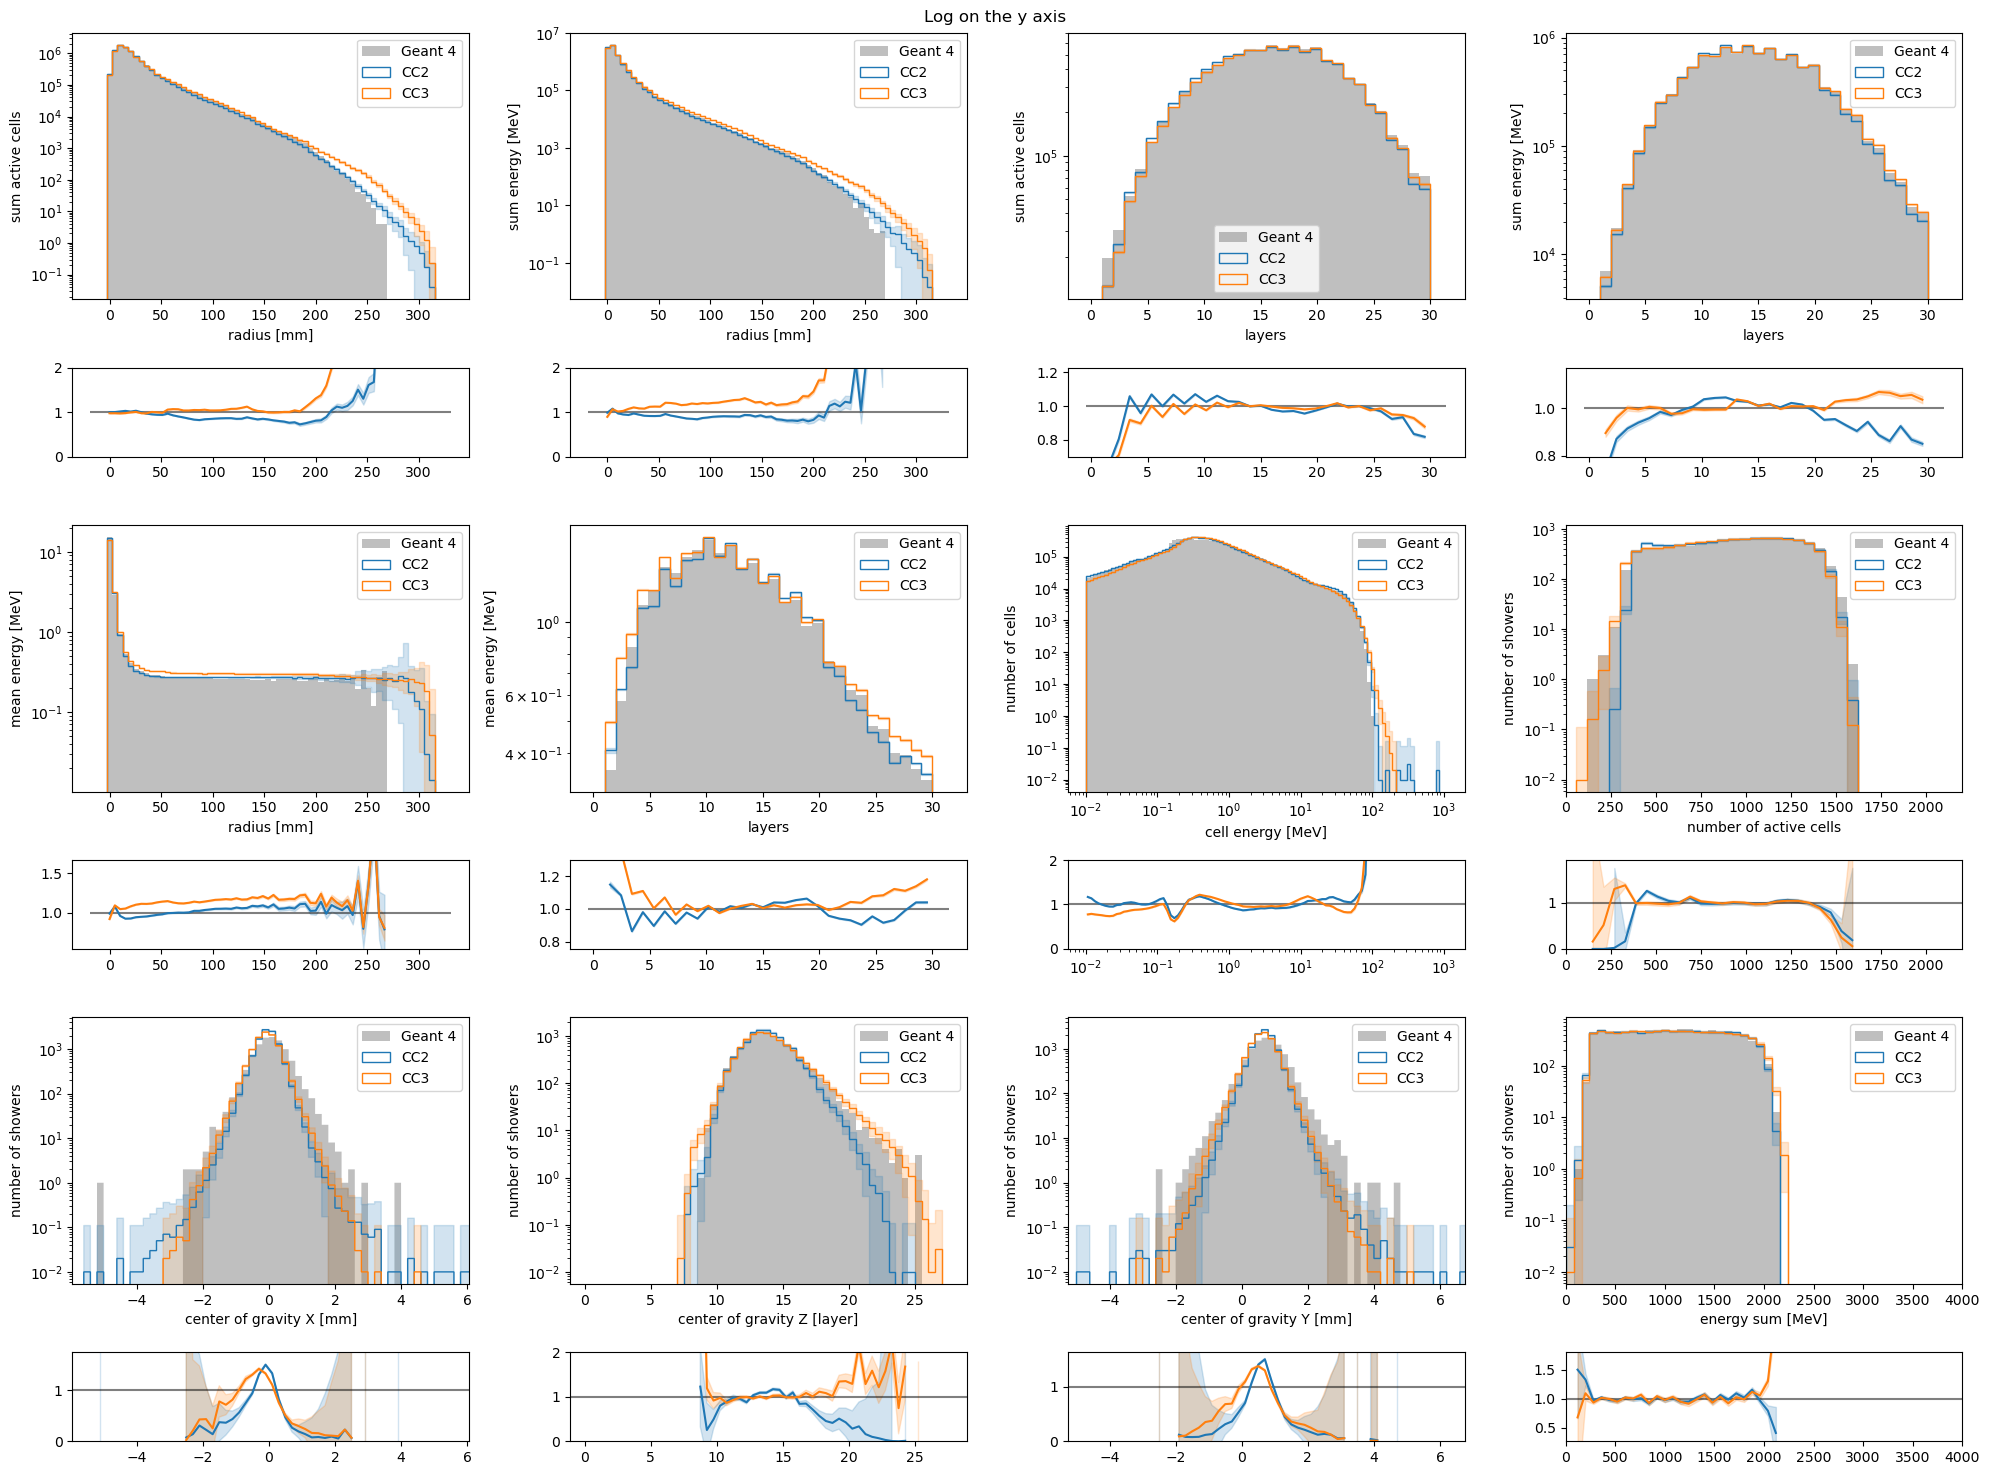

In [10]:
#reduced = {k:to_compare_proj[k] for k in ["CC2", "CC3"]}
reduced = {}
#reduced["Geant 4"] = to_compare_proj["Geant 4"]
reduced["CC2"] = to_compare_proj["CC2 noCoG"]
reduced["CC3"] = to_compare_proj["CC3 noCoG"]
make_hist_plots(binned_g4_proj, reduced, save_tag="noCoG_withErr")

('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')
('radius [mm]', 'sum active cells')
('radius [mm]', 'mean energy [MeV]')
('center of gravity X [mm]', 'number of showers')
('radius [mm]', 'sum energy [MeV]')
('layers', 'mean energy [MeV]')
('center of gravity Z [layer]', 'number of showers')
('layers', 'sum active cells')
('cell energy [MeV]', 'number of cells')
('center of gravity Y [mm]', 'number of showers')
('layers', 'sum energy [MeV]')
('number of active cells', 'number of showers')
('energy sum [MeV]', 'number of showers')


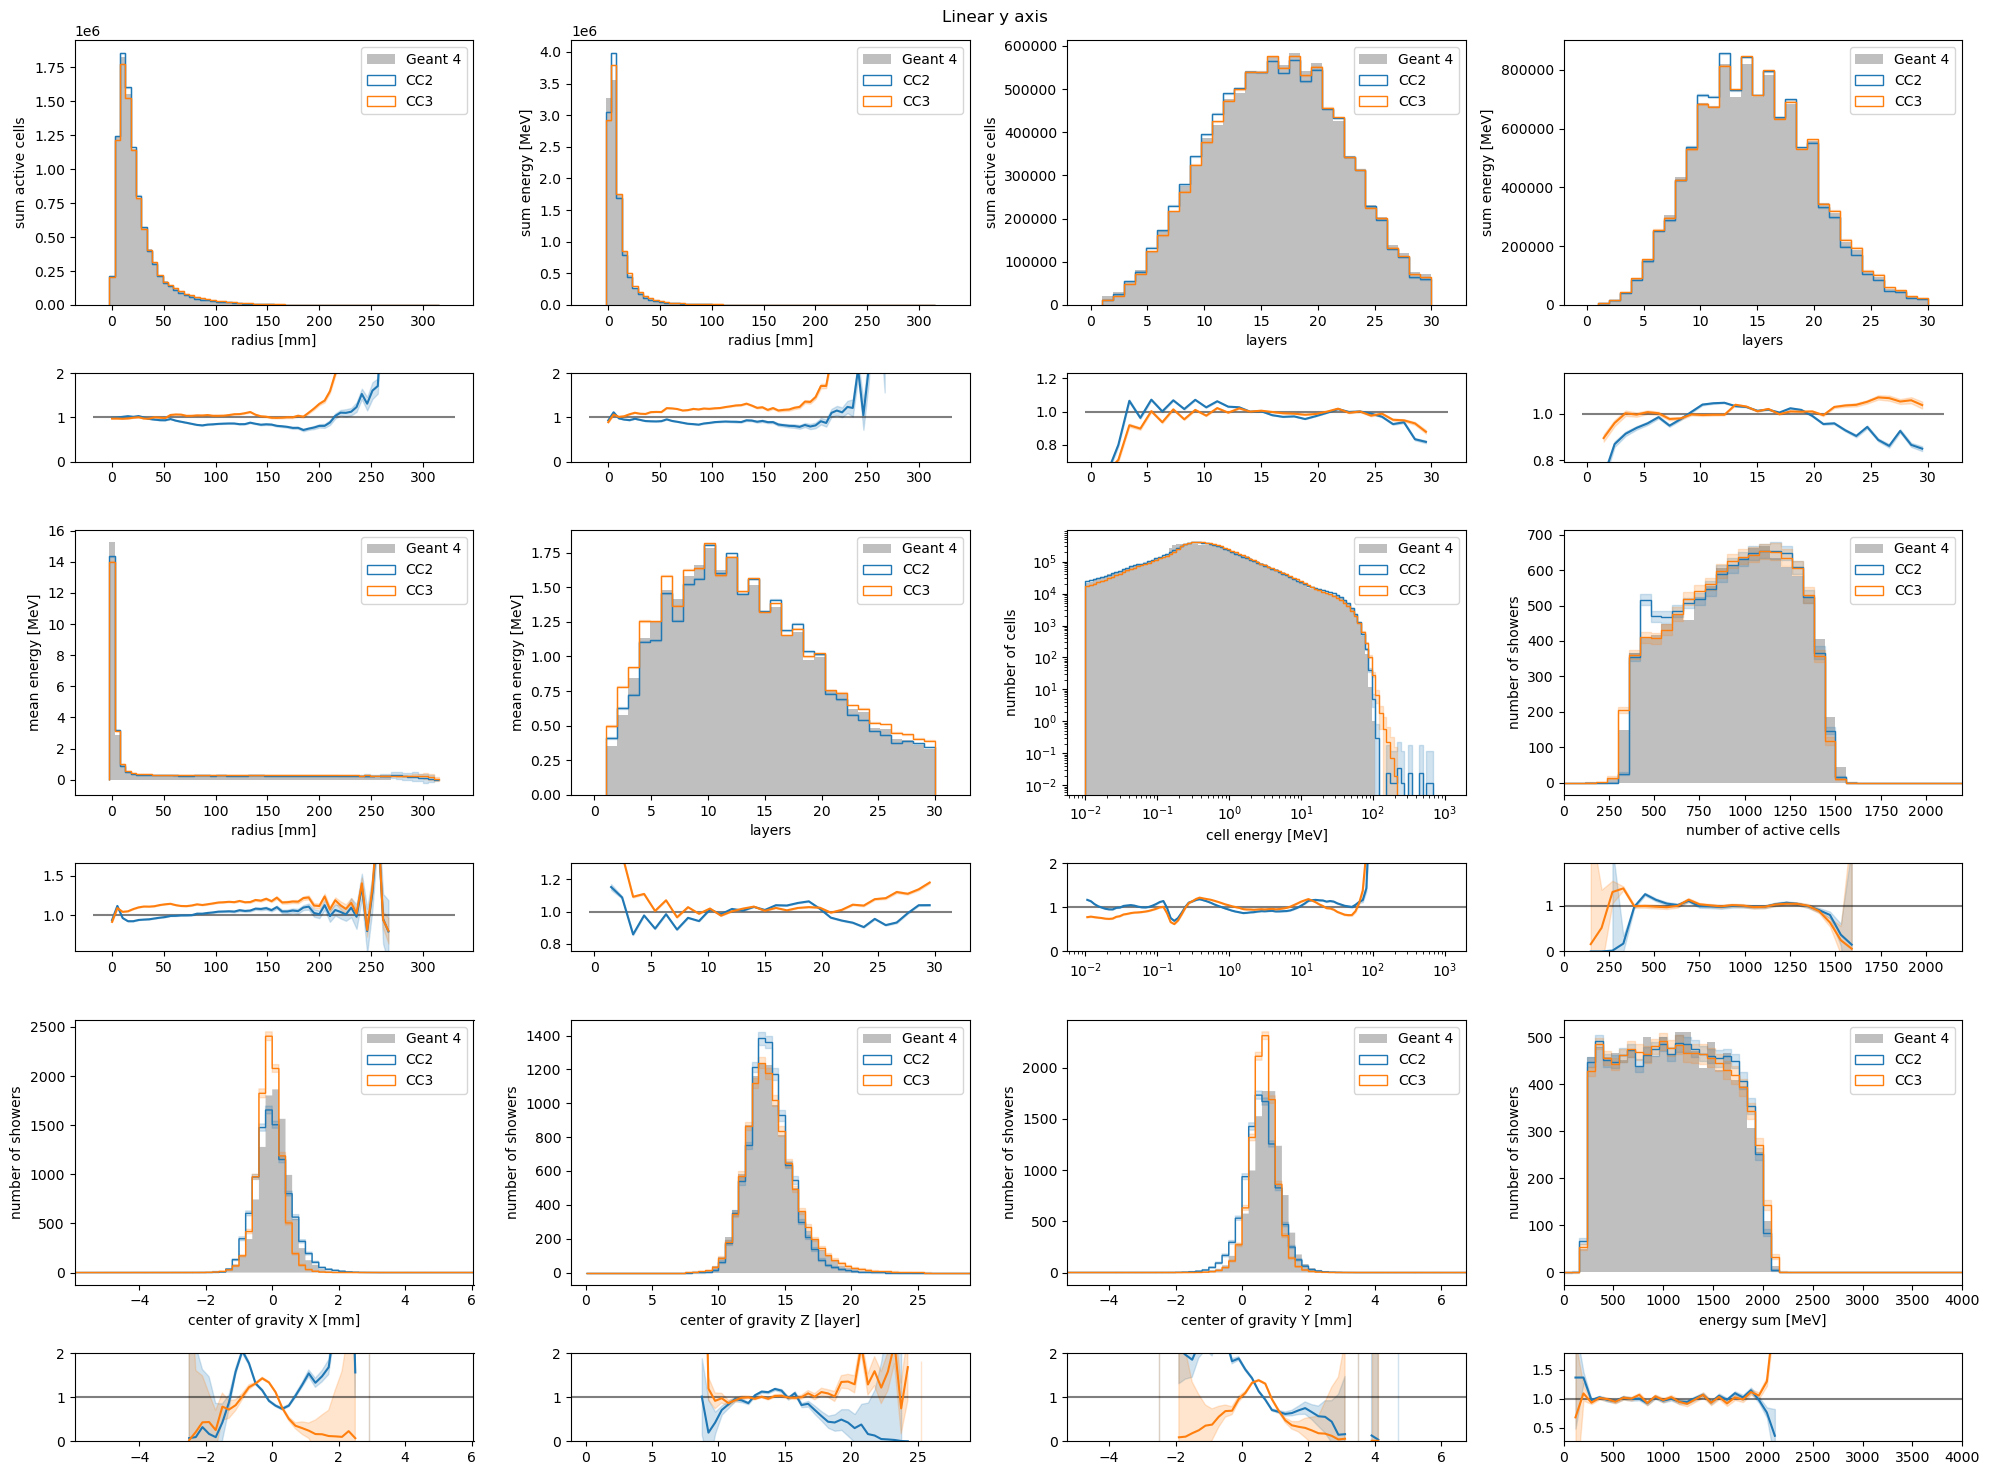

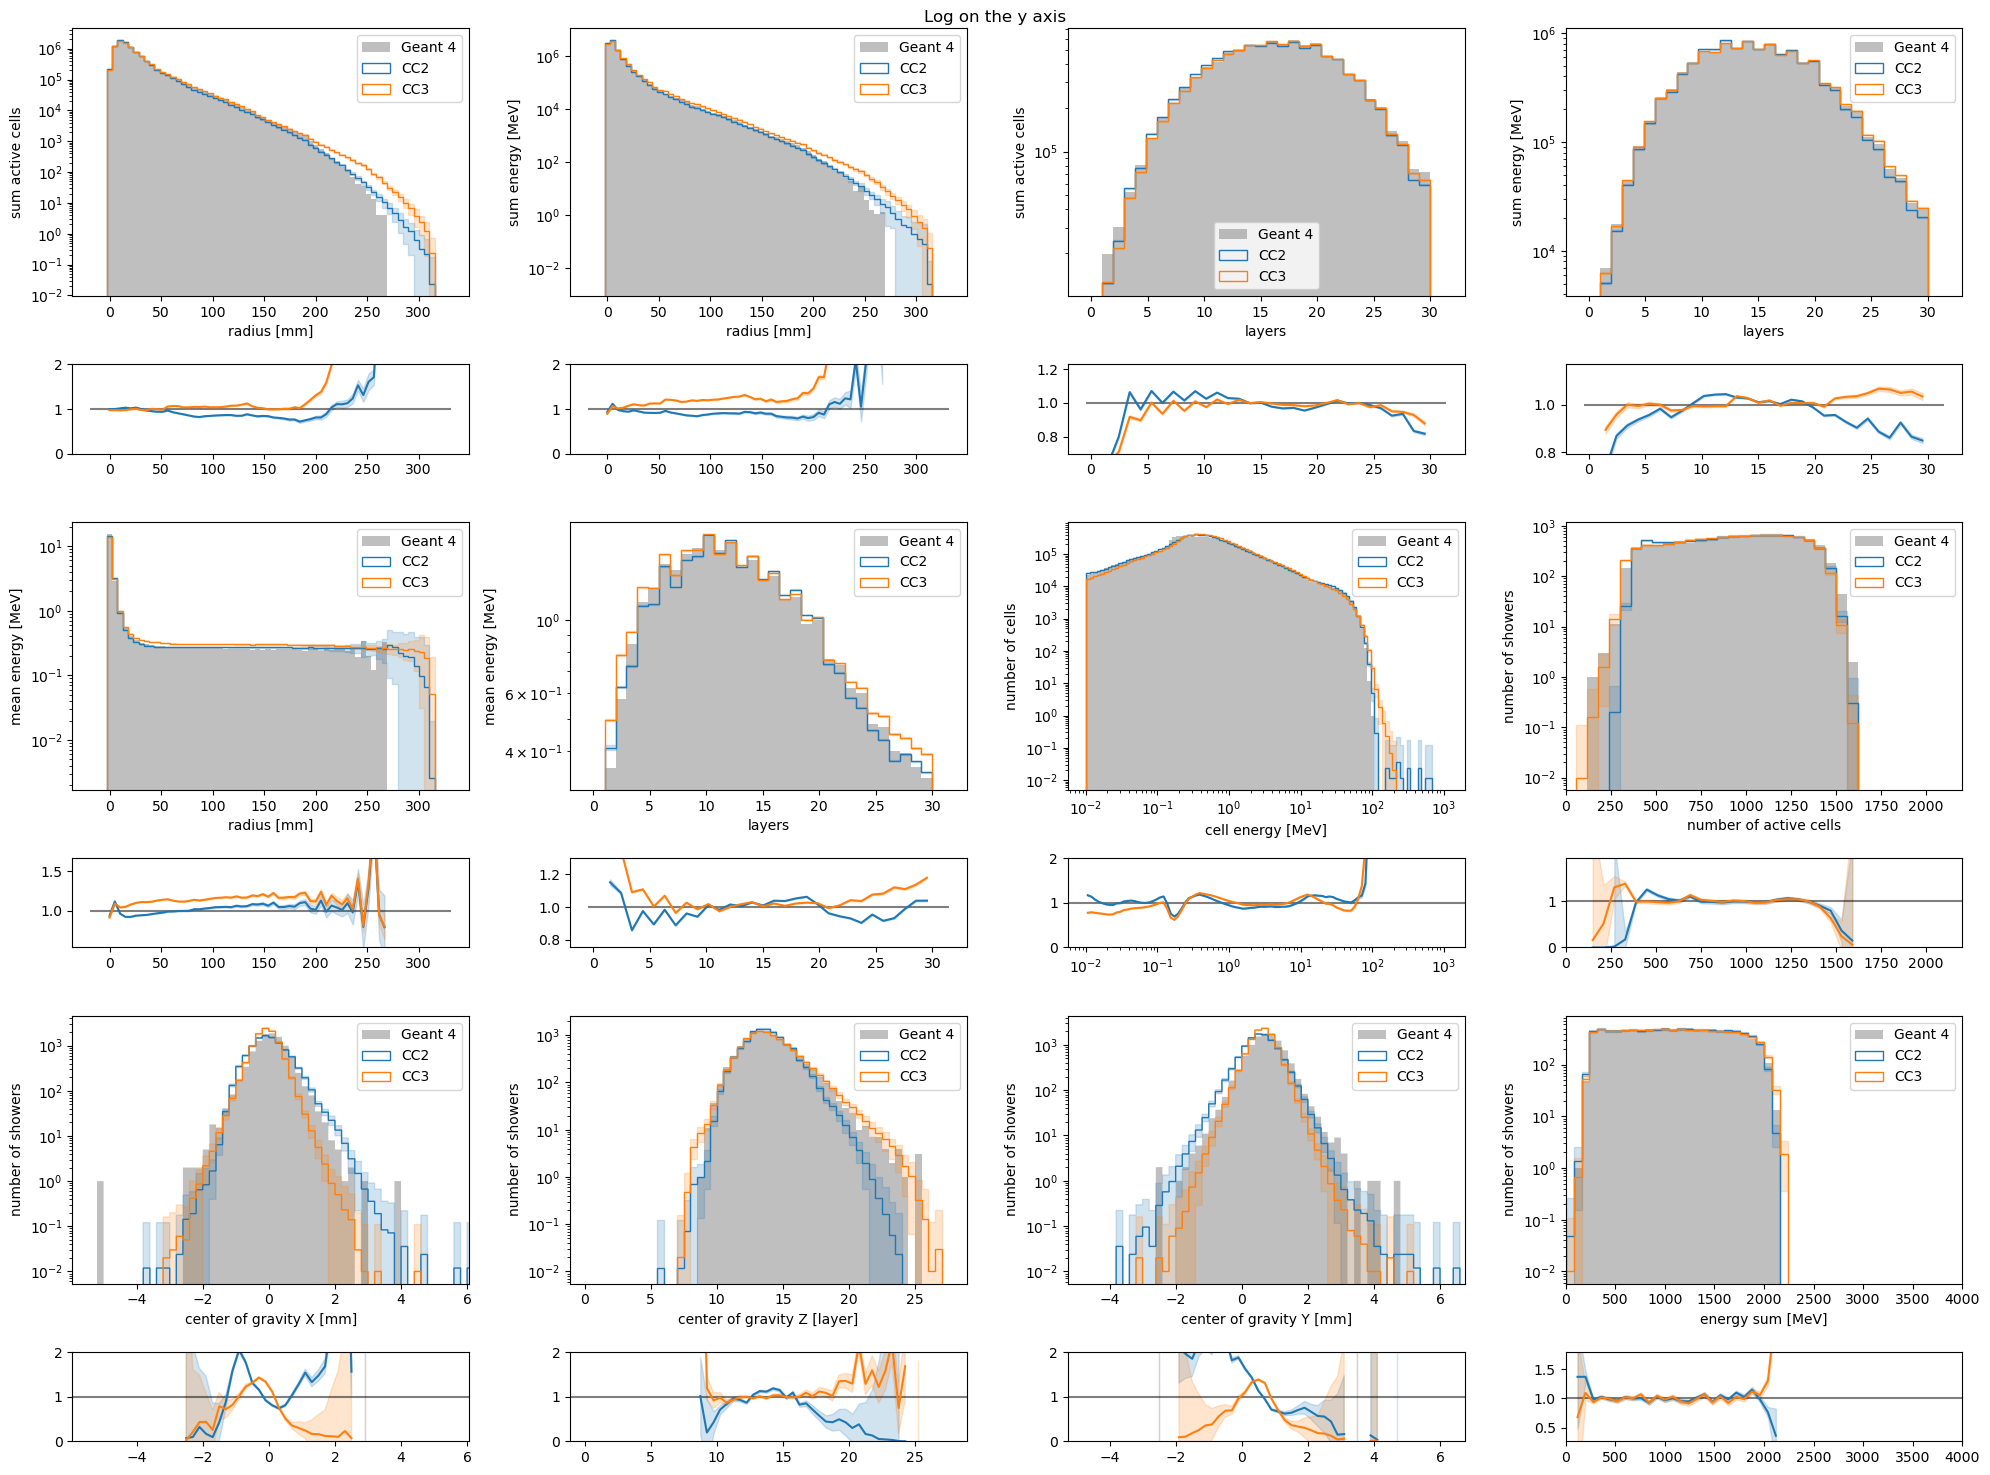

In [11]:
#reduced = {k:to_compare_proj[k] for k in ["CC2", "CC3"]}
reduced = {}
#reduced["Geant 4"] = to_compare_proj["Geant 4"]
reduced["CC2"] = to_compare_proj["CC2"]
reduced["CC3"] = to_compare_proj["CC3 noCoG"]
make_hist_plots(binned_g4_proj, reduced, save_tag="mixed_withErr")